# Comparing test sample classification between KNN and SVC binary classifiers

This study aims at comparing two binary classifiers on the basis of their "confidence" as quantified by predicted probabilities. The vehicles.csv dataset that has been used so far requires multiclass classification because its response variable has 4 classes. In order to carry out this study, a bi-class dataset was needed so there were two possible approaches:
The first approach considers adjusting the vehicles.csv dataset by dropping all but two classes.

In [1]:
import k_nn
import s_v_m
import explore_datav2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from load_dataset import load_dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

## Loading and preprocessing of the dataset

### Method 1
The vehicles.csv dataset is used. It's target variable has four possible classes `['bus' 'opel' 'saab' 'van']` as observed by running `np.unique(target)`. However, the initial phase of this study is centered on binary classification and so the dataset is modified such that only two classes are left.

In [2]:
#Data set is loaded into a pandas dataframe
filename = "vehicles.csv"
df = load_dataset(filename)

"""Remove all observations that do not belong to either class 'opel' or class 'bus'. 
The choice of the classes to evaluate was arbitrary."""

opel = df["Class"]=='opel'
bus = df['Class']=='bus'

print("The initial shape of the dataset is {}".format(np.shape(df)))

df = df[bus | opel]
print("The new shape of the dataset is {}".format(np.shape(df)))

#Separate the feature and response variables of the dataset.
data = df.drop("Class", axis=1)
target = df["Class"]

print("The classes of the target variable after adjustment are {}".format(np.unique(target)))


The initial shape of the dataset is (846, 19)
The new shape of the dataset is (430, 19)
The classes of the target variable after adjustment are ['bus' 'opel']


It is noticed that 416 observations were lost, accounting for 49 percent of the dataset. This is a significant chunk of data and considering that the new dataset has far less than 10,000 samples, there is a high risk of underfitting. Therefore, for this study, the `defaults.csv` dataset is used instead which has just two classes.

### Method 2

The defaults.csv dataset is loaded into a pandas dataframe using the `load_dataset` module. Its target variable (`defaulted`) is then separated from the independent variables and the `train_test_split` function from the `model_selection` module of scikit learn is used to split the dataframe content into training and test sets. The train/test ratio used is 70/30.

In [3]:
filename = "defaults.csv"
df = load_dataset(filename)

data = df.drop("defaulted", axis=1)
target = df["defaulted"]
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.30, stratify=target, random_state=42)

## Part one : Visualising predicted class probabilities.

## KNN
A KNN model is fitted to the training set. A tuned value of the `n_neighbors` hyperparameter is used to ensure optimum results. The arrangement of the classes is observed using the `.classes_` attribute. This eases the understanding of the results that will be produced by `predict_proba` later on.

In [4]:
n = int(k_nn.tune(data_train, target_train))
""" The param_val value is converted from the numpy.int64 type to an integer in order to make it appropriate
for use as a parameter of the classifier."""
knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(data_train, target_train)
print(knn.classes_)

[0 1]


The classes are arranged such that class0 comes before class1. Hence in the results of `predict_proba`, the first column will be the probability that the sample belongs to class0 while the second column will be the probability that the sample belongs to class1. In this study, **class1 is considered the positive class** .

### Exploring predict_proba()

For binary classification, predict_proba returns two columns. Considering the previous statements, the first column is the represents the probability of `False` and the second column represents the probability of `True` (This is because the second column represents the probability of class1 and class1 is considered the positive class).

In [5]:
pred_prob_knn_full=knn.predict_proba(data_test)
pred_prob_knn = knn.predict_proba(data_test)[:,1]

In [6]:
print("The shape of the test data is {}".format(np.shape(data_test)))
print("predict_proba returns an object of shape {} ".format(np.shape(pred_prob_knn_full)))
print("predict_proba returns an object of shape {} and type {} with dimensions {}".format(np.shape(pred_prob_knn_full), type(pred_prob_knn_full), np.ndim(pred_prob_knn_full)))

The shape of the test data is (9000, 24)
predict_proba returns an object of shape (9000, 2) 
predict_proba returns an object of shape (9000, 2) and type <class 'numpy.ndarray'> with dimensions 2


It is observed that the shape of the test data is `(n_samples, n_features)`, and that predict_proba() returns a two dimensional numpy array of shape `(n_samples, n_classes)`. The `predict_proba()` function returns a list of list; one list per observation.
The index 1 values of predict_proba() are plotted in order to analyse the probability of being in the positive class.

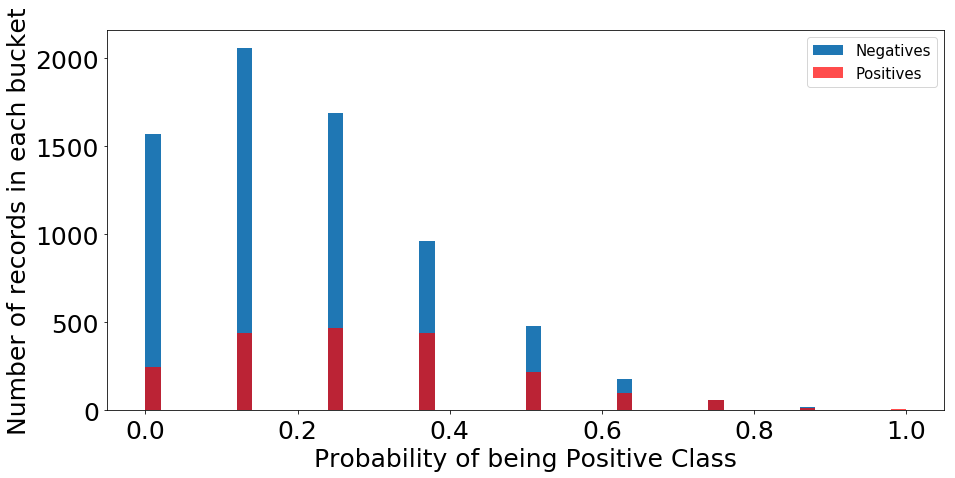

In [7]:
plt.figure(figsize=(15,7))
plt.hist(pred_prob_knn[target_test==0], bins=50, label='Negatives')
plt.hist(pred_prob_knn[target_test==1], bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

It is observed that when the true values are negative, the predicted probability of being in the positive class tends to be really low. That is, the lower the probability of being in the positive class, the higher the tendency that that sample actually belongs to the negative class.
However, when the true values are positive(red), the model still seems to have very little confidence in its prediction. This is because a chunk of the samples which have true positive values are still predicted with very low probability.
Overall, the KNN model has a low confidence level with respect to the `defaults.csv` dataset.

## SVC
In the same way, the probability of the positive class, when a support vector classifier is used, is plotted.

In [ ]:
params = s_v_m.tune(data_train, target_train)
print(params)

In [ ]:
#get tuned hyperparameters
params = s_v_m.tune(data_train, target_train)
svc = SVC(**params,probability=True)
svc.fit(data_train, target_train)
#use fitted model to get prediction probabilities
pred_prob_svc=svc.predict_proba(data_test)[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[target_test==0], bins=50, label='Negatives')
plt.hist(prediction[target_test==1], bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

## Part two : Heat map visualisation of model Confusion matrices
The models are trained and tested in their respective modules. The accuracy scores and predicted values are unpacked into variables. The predicted values for each model will be used to visualise the performance of that model on a confusion matrix.

In [ ]:
acc_knn, target_pred_knn = k_nn.k_nearest(data_train=data_train, target_train=target_train, data_test=data_test, target_test=target_test)
acc_svc, target_pred_svc = s_v_m.s_vee_c(data_train, data_test,target_train, target_test)

Each array of predicted values is converted into a list.

In [ ]:
for a in [target_pred_knn, target_pred_svc]:
    a = list(a)

In [ ]:
conf_matrix_knn = confusion_matrix(target_test, target_pred_knn)   
conf_matrix_svc = confusion_matrix(target_test, target_pred_svc)

The `confu_matrix_display()` function in the explore_datav2 module is used to display the confusion matrices.

In [ ]:
plt.subplot(2,1,1)
explore_datav2.confu_matrix_display(conf_matrix_knn, target)
plt.title("KNN")
plt.subplot(2,1,2)
explore_datav2.confu_matrix_display(conf_matrix_svc, target)
plt.title("SVC")
plt.show()


The predicted values and true values, gotten from `target_test` are combined into a dataframe on which further research can be carried out.

In [ ]:
combi_dict = {"Ref":list(target_test)}
compare_df = pd.DataFrame(combi_dict, columns=["Ref"])
compare_df["KNN"] = target_pred_knn
compare_df["SVC"] = target_pred_svc

## Side note
In order to give context, and ease the understanding of the first visualisations where the probability of being in the positive classs was observed, below is a demonstration of expected behaviour of a good model.

In [ ]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=1, shuffle=False)
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression(random_state=0, solver='lbfgs', max_iter=10)
lr.fit(X, y)

prediction=lr.predict_proba(X)[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[y==0], bins=50, label='Negatives')
plt.hist(prediction[y==1], bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()